## Understand Your Audience - Large Scale User Community Detection Using Spark

We show how a Spark based analysis pipeline can be used to discern distinct user communities from large volumes of data based on polarizing opinions expressed by the users.


Understanding your user base for the purposes of targeted campaigning is critical to many businesses. Services such as Twitter enable us to study the opinions of large groups regarding world events in near real time. However obtaining useful insights from high volume and high frequency data sources like Twitter data presents many challenges. We have created a data application that provides an interface for exploring communities of Twitter users around a specific topic. It is intriguing to see that highly polarizing topics can generate networks of users that exhibit well defined communities with distinct viewpoints. We use Spark Word2Vec to obtain a set of related terms based an initial user query, which defines a topic. From this we generate a user conversation graph about the topic, which represents alignment of opinion among users. Community detection algorithms then discovers communities in this graph, and allows for study of each community regarding the topic. Apache Spark is used to manage, filter and manipulate high volume data from Twitter Decahose.

<img src="architecture_diagram_2.jpg" alt="Drawing" style="width: 700px;"/>

In [1]:
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, udf
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.feature import Word2Vec, Word2VecModel

import re
import operator
import requests
import numpy as np
import pandas as pd
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
%load_ext autoreload
pd.set_option('max_colwidth', 150)

import sys
sys.path.append("/home/iyounus/src/NetworKit")
from networkit import *

### Input Data: Retweets

Filtered English tweets, stored in parquet files, are read into __Spark DataFrame__. Here we select retweets for specific dates. The data also includes sentment for each tweet which is generated using SentiWordNet 3.0.

In [2]:
start_date = "2016-05-02"
end_date = "2016-05-04"

df_raw = sqlContext.read.parquet("hdfs://spark-dense-01:8020/tiara/en") \
            .filter("postedDate >= '" + start_date + "'") \
            .filter("postedDate <= '" + end_date + "'") \
            .filter("verb = 'share'") \
            .select(col("actor.preferredUsername").alias("uid"), \
                    col("object.actor.preferredUsername").alias("ouid"), \
                    col("object.body"), col("sentiment"))
df_raw.show(5)

+---------------+-------------+--------------------+---------+
|            uid|         ouid|                body|sentiment|
+---------------+-------------+--------------------+---------+
|        fifahsy|  samuel_liew|when White ppl la...|        0|
|   mentallyIost|ifeelglorious|Summer plans http...|        0|
|Subratobiswas20|importantmeji|Unfortunate Peopl...|       -1|
|       dreamof7|      lildurk|Stop tryna find l...|        1|
|      I_Skyla_I|   MamsiRamzi|@MarionSpekker go...|        1|
+---------------+-------------+--------------------+---------+
only showing top 5 rows



### Word2Ved Model

We generate [__Word2Vec__](https://en.wikipedia.org/wiki/Word2vec) model, using __Spark ML__, from English tweets for one week. The trained model is stored in HDFS, and is loaded here for further use.

In [3]:
w2v_url = "hdfs://spark-dense-01:8020/tiara/models/days=10/2016-04-25/w2v"
w2v = Word2VecModel.load(sc, w2v_url)
df_w2v = sqlContext.read.parquet(w2v_url + "/data")

### Topic Curation

We wish to select retweets related to a specific topic of discussion. A topic filter is defined using one search term and then finding top 20 related terms using word2vec model.

In [4]:
term = u"#bernie"

def synonyms(w, n=20):
    key_words = w2v.findSynonyms(w, 200)
    key_words = [word for word, dist in key_words if "#" in word][:n-1]
    key_words.insert(0, term)
    return key_words

key_words = set(synonyms(term))

### PCA

To visualize the terms, we use __Spark PCA__ to transform 200 dimensional word vectors generated by Word2Vec model. A scatter plot using first two principle components provides a good visualization for the terms.

In [5]:
def normalize(x):
    return x / np.linalg.norm(x)

m = df_w2v.select(df_w2v['vector']).map(lambda x: np.array(x[0])).mean()
dfZeroMean = df_w2v.map(lambda x: (x[0], Vectors.dense(normalize(np.array(x[1])-m)))).toDF(["word", "vector"])

pca = PCA(k=2, inputCol="vector", outputCol="pca")
model = pca.fit(dfZeroMean)
transformed = model.transform(dfZeroMean).persist()

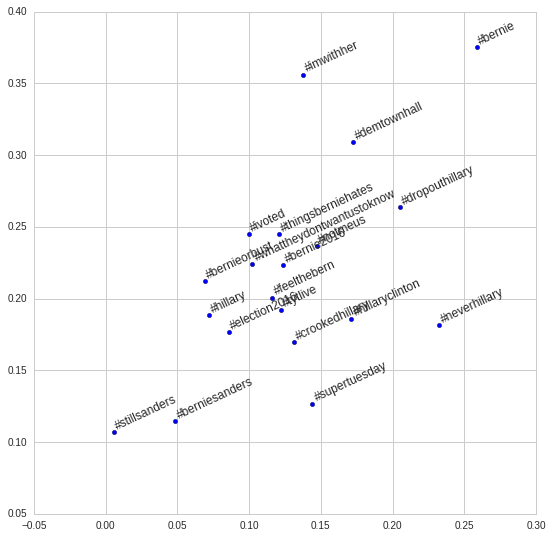

In [6]:
word_vec = transformed.filter(col("word").isin(key_words)).select("word", "pca").map(
    lambda x: (x[0], x[1][0], x[1][1])).collect()

X1 = [v1 for w,v1,v2 in word_vec]
X2 = [v2 for w,v1,v2 in word_vec]
plt.figure(figsize=(9,9))
plt.scatter(X1, X2);
for i, txt in enumerate(key_words):
    plt.annotate(txt, (X1[i], X2[i]), size=12, rotation=25, verticalalignment='left')

### Retweets for Selected Topic

We use simple regex filter created from 20 terms to select retweets discussing the specific topic. The filtered dataframe is quite small, therefore we convert it to pandas dataframe.

In [7]:
reg = "(?i) (" + "|".join(key_words) + ") "
print(reg)

df_reg = df_raw.filter(df_raw["body"].rlike(reg))
sub_link = udf(lambda txt : re.sub('(https?:\/\/[A-Za-z0-9_\/\.]+)|(\&amp;)|(\n)',' ', txt))
df = df_reg.withColumn("tweets", sub_link(df_reg.body)).drop(df_reg.body).toPandas()
df.info()
df.head()

(?i) (#bernie2016|#hillary|#neverhillary|#notmeus|#ivoted|#imwithher|#tytlive|#bernie|#berniesanders|#election2016|#crookedhillary|#feelthebern|#dropouthillary|#demtownhall|#hillaryclinton|#bernieorbust|#supertuesday|#whattheydontwantustoknow|#thingsberniehates|#stillsanders) 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36464 entries, 0 to 36463
Data columns (total 4 columns):
uid          36464 non-null object
ouid         36464 non-null object
sentiment    36464 non-null int64
tweets       36464 non-null object
dtypes: int64(1), object(3)
memory usage: 1.1+ MB


,uid,ouid,sentiment,tweets
0,TKYSK8R,JordanChariton,0,"Watching stuff like this makes me wonder, ""Gee...is television news motivated 2 get @BernieSanders to drop out?"" #FeeltheBern #tytlive"
1,RMcKitrick,Lonestarmomcom,0,"Like our friend @TheRickWilson said, the only way #trump beats #Hillary is w/golf club😂😂😂😂"
2,Deb_57,Libertea2012,-1,RT #OhHellNo NEVER WARMONGER HRC #NeverHillary Hillary is SO VERY VERY DANGEROUS to AMERICA! Don't vote4HRC #Bern :…
3,naveenchenna,Bill_Cimbrelo,0,(UNBELIVEABLE) Hillary Clinton laughs about possible war against iran #StillSanders #FeelTheBern #NeverHillary
4,ItMustBeNice1,Mama_Jones2013,0,Hillary Clinton is the most prepared and qualified presidential candidate ever. #WhatTheyDontWantUsToKnow #ImWithHer


### Generating Graph Data

In order to generate users graph, we create an edge-list from the user pairs (uid, ouid). Each edge is assigned a weight given by the number of times user pairs appear in the datafram. The edge list with weights is temporarily saved as a csv file.

In [8]:
# create edge list
df['edge'] = df["ouid"].map(str) + "," + df["uid"].map(str)
df_edge = df['edge'].value_counts().to_frame('weight')
df_edge.reset_index(level=0, inplace=True)
df_edge[['ouid','uid']] = df_edge['index'].str.split(',', expand=True)
df_edge.drop('index', axis=1, inplace=True)

df_edge.info()
print(df_edge.head())

edge_list_1 = "/home/iyounus/twitter_graph_ana/edgelist_temp.csv"
df_edge[["uid","ouid","weight"]].to_csv(edge_list_1, header=False, index=False, sep=',')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34955 entries, 0 to 34954
Data columns (total 3 columns):
weight    34955 non-null int64
ouid      34955 non-null object
uid       34955 non-null object
dtypes: int64(1), object(2)
memory usage: 819.3+ KB
   weight             ouid              uid
0      17  Angelsmyname777   Conserv4Bernie
1      15     world_bernie       dale_ruffo
2      14     Libertea2012      pollyantics
3      14      AngryVoters  Colorado4Bernie
4      14         BioWreck   the_fire_berns


### Processing Graph using NetworKit

We use NetworKit package to create graph from the edge list.

In [9]:
reader = graphio.getReader(Format.EdgeList, separator=',', continuous=False) #, directed=True)
g = reader.read(edge_list_1)
g.removeSelfLoops()

nodeMap = reader.getNodeMap()
invNodeMap = {v: k for k, v in nodeMap.items()}

print("Number of nodes: " + str(g.numberOfNodes()))
print("Number of edges: " + str(g.numberOfEdges()))

Number of nodes: 23634
Number of edges: 34933


### Core Decomposition

The original graph created from the edge list contains several low degree nodes. We remove peripheral nodes using [k-core decomposition](https://en.wikipedia.org/wiki/Degeneracy_%28graph_theory%29). All k-core 1 nodes are removed. Following histogram shows k-core distribution for all nodes.

6319
Number of nodes: 6319
Number of edges: 19038


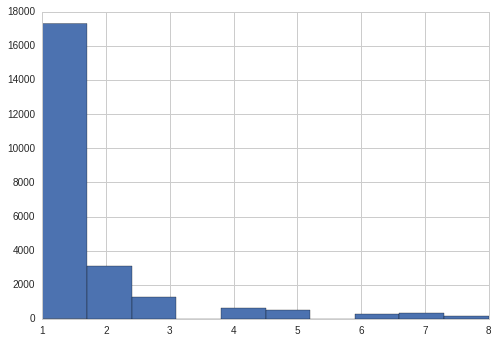

In [10]:
coreDec = centrality.CoreDecomposition(g)
coreDec.run()
plt.hist(coreDec.scores());

v = [node for node in g.nodes() if coreDec.score(node) > 1]
print(len(v))

gsub = g.subgraphFromNodes(v)
print("Number of nodes: " + str(gsub.numberOfNodes()))
print("Number of edges: " + str(gsub.numberOfEdges()))

### Community Detection

We use [Parallel Louvain Method](https://en.wikipedia.org/wiki/Louvain_Modularity) to find communities of users from the filtered retweet graph. The resolution parameter is adjusted to maximize the [modularity](https://en.wikipedia.org/wiki/Modularity_%28networks%29). We only keep large communities that contain 90% of the nodes. Finally, the node list and the associated community label are stored in pandas dataframe.

PLM(balanced,pc,turbo) detected communities in 0.0635530948638916 [s]
solution properties:
-------------------  -----------
# communities          11
min community size      4
max community size   3885
avg. community size   574.455
modularity              0.414507
-------------------  -----------


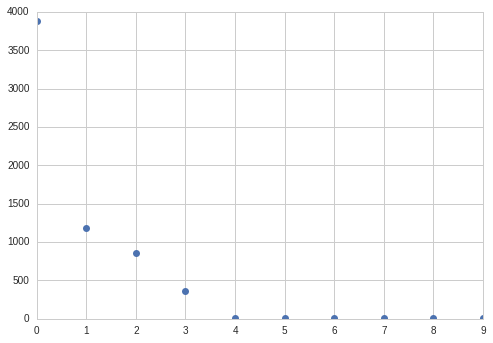

In [11]:
communities = community.detectCommunities(gsub, algo=community.PLM(gsub, False, 0.5))
comm_size = communities.subsetSizeMap()
sorted_s = sorted(comm_size.items(), key=operator.itemgetter(1), reverse=True)
top_comm = [x for x,y in sorted_s[:10]]
top_comm_size = [y for x,y in sorted_s[:10]]
plt.plot(top_comm_size, 'o');

In [12]:
def top_communities(comm_size):
    current = 0.0
    total = sum(comm_size)

    for i, s in enumerate(comm_size):
        current += s
        if current/total > 0.9:
            return i+1

n_comm = top_communities(top_comm_size)

In [13]:
node_labels = []
for i, comm in enumerate(top_comm[:n_comm]):
    nodes = communities.getMembers(comm)
    print(comm, len(nodes))
    node_labels.extend([(invNodeMap.get(node), node, i+1) for node in nodes])

df_temp = pd.DataFrame(node_labels, columns=['uid', 'id', 'community'])

0 3885
7 1184
4 852


### Force Directed Layout

To visualize the community structure in the graph, we use [ForceAtlas2 algorithm](https://en.wikipedia.org/wiki/Force-directed_graph_drawing) from Gephi. Since Gephi doesn't provide a python api, we've created a rest server for layout algorithm. This rest server receives an edge list, and returns coordinates for the layout. The coordinates are stored in a pandas dataframe which is joined with the nodes dataframe from previous section.

In [14]:
ed = gsub.edges()
edge_list_2 = "/home/iyounus/twitter_graph_ana/edgelist_temp_short.csv"

with open(edge_list_2, "w") as f:
    for u, v in ed:
       f.write(invNodeMap.get(u) + "," + invNodeMap.get(v) + "," + str(gsub.weight(u,v)) + "\n")
f.close()

url = 'http://spark11:16666/tiara/gephi-layout?graph=' + edge_list_2 + '&threshold=100.0'
resp = requests.get(url)
if resp.status_code != 200:
    print('gephi server error')
else:
    data = resp.json()

In [15]:
df_xyz = pd.DataFrame(data['nodes'], columns=['uid','degree','x','y','z'])

df_xyzc = pd.merge(df_temp, df_xyz, how='left', left_on='uid', right_on='uid')
df_xyzc.info()
df_xyzc.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5921 entries, 0 to 5920
Data columns (total 7 columns):
uid          5921 non-null object
id           5921 non-null int64
community    5921 non-null int64
degree       5921 non-null object
x            5921 non-null float64
y            5921 non-null float64
z            5921 non-null int64
dtypes: float64(2), int64(3), object(2)
memory usage: 370.1+ KB


,uid,id,community,degree,x,y,z
0,Conserv4Bernie,0,1,1,332.273438,-568.592590,0
1,Angelsmyname777,1,1,0,356.481842,-558.396973,0
2,dale_ruffo,2,1,3,128.333862,-702.778748,0
3,world_bernie,3,1,2,157.371490,-688.109253,0
4,pollyantics,4,1,5,202.628891,-320.969696,0


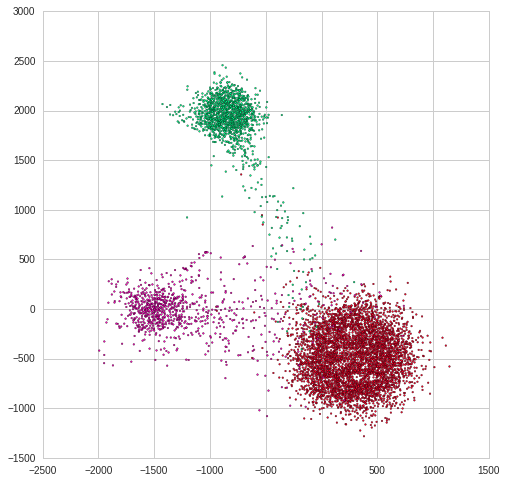

In [16]:
plt.figure(figsize=(8,8))
plt.scatter(df_xyzc['x'], df_xyzc['y'], s=3, c=df_xyzc['community'], cmap=plt.cm.gist_rainbow);

###  Understanding The Communities

To summarize the discussions in these communities we use wordclouds which provide visual representations of words being used the discussions. We also use sentiment analysis to gauge over all sentiment of the communities.

In [17]:
df_comm = pd.merge(df_temp, df[['uid','tweets','sentiment']], how='inner', left_on='uid', right_on='uid')#.drop(df_temp.uid)
df_comm.head()

,uid,id,community,tweets,sentiment
0,Conserv4Bernie,0,1,"Dear @MaggieALewis, There's huge support for #Bernie2016 in Indiana. Please consider endorsing him. #INPrimary",1
1,Conserv4Bernie,0,1,"Dear @MartyBlock39, There's huge support for #Bernie2016 in California. Please consider endorsing him. #CAPrimary",1
2,Conserv4Bernie,0,1,Pierce Cty #WACaucus passes resolution that WASuperDelegates' votes reflect will of ppl or be denied $! #FeelTheBern,1
3,Conserv4Bernie,0,1,"Dear @repsteveriggs, There's huge support for #Bernie2016 in Kentucky. Please consider endorsing him. #KYPrimary",1
4,Conserv4Bernie,0,1,"#Superdelegate Christine Bremer Muggli, please consider the will of your constituents support #BernieSanders for the Dem nomination.",1


In [18]:
from utils import tokenize
%autoreload 2

def draw_sentiment(ax, l):
    bar_width = 2.0
    y_offset = 0
    colors = plt.cm.BuPu(np.linspace(0, 0.5, 3))
    senti = ["Neutral", "Negative", "Positive"]
    ax.set_xlim(0, 5.0)
    for i in range(3):
        ax.bar(0, l[i], bar_width, bottom=y_offset, color=colors[i])
        ax.annotate(("%1.0f" % (l[i]*100)) + "% " + senti[i] , xy=(2.2, y_offset + l[i]/2.0 - 0.02), size=12)
        y_offset = y_offset + l[i]
    

def draw_word_cloud(ax, text):
    wc = WordCloud(ranks_only=True, background_color="white")
    wordcloud = wc.generate(" ".join(text))
    ax.imshow(wordcloud)


def draw_info(df, m):
    fmod = df[df['community']==m]
    df_count = fmod[['sentiment','tweets']].groupby(['sentiment']).count()
    l = [float(x[0]) for x in df_count.values]

    plt.figure(figsize=(12,4))
    ax1 = plt.subplot2grid((1, 11), (0, 9), colspan=2)
    ax1.axis("off")
    ax2 = plt.subplot2grid((1, 11), (0, 1), colspan=8)
    ax2.axis("off")
    
    if (len(l) == 3):
        s = sum(l)
        l = [l[1]/s, l[0]/s, l[2]/s]
        draw_sentiment(ax1, l)
   
    text = list(fmod['tweets'].drop_duplicates().values)
    print("Number of retweets " + str(len(text)) + " for community " + str(m))
    text = tokenize(text)

    draw_word_cloud(ax2, text)
    plt.tight_layout()

Number of retweets 7237 for community 1
Number of retweets 1776 for community 2
Number of retweets 836 for community 3


[None, None, None]

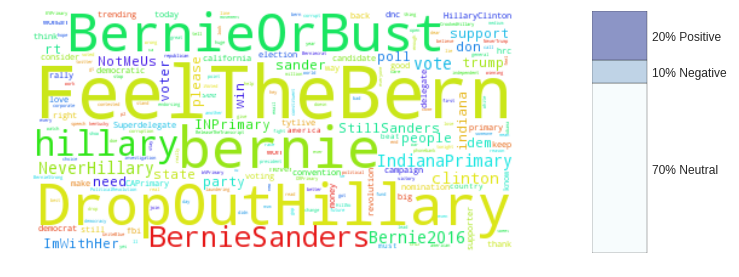

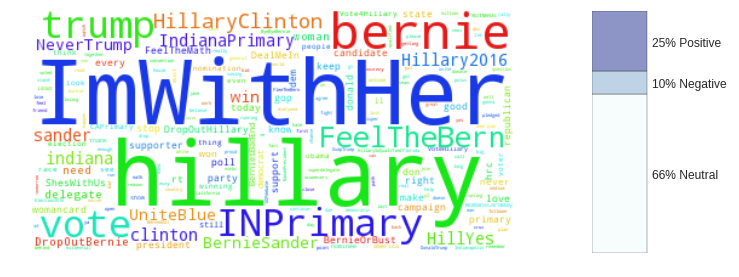

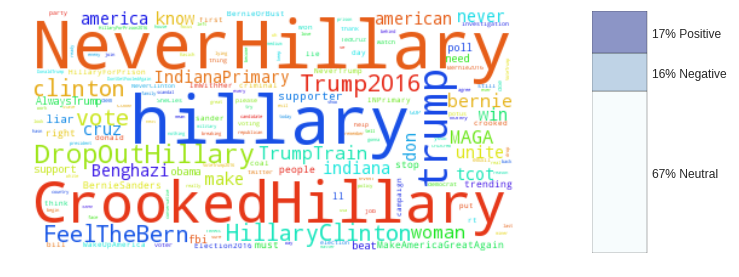

In [19]:
[draw_info(df_comm, m+1) for m in range(n_comm)]